In [1]:
__author__ = 'Robert Nikutta <nikutta@noao.edu>, NOIRLab Astro Data Lab team <datalab@noao.edu>'
__version__ = '20200904' # yyyymmdd
__datasets__ = ['allwise','smash']
__keywords__ = ['histogram','plot:cmd','RRLyrae','lightcurve','dwarf galaxies','query','tutorial']

# Data Lab data access examples
*Robert Nikutta and the NOIRLab Astro Data Lab Team*

### Table of contents
* [Goals & notebook summary](#goals)
* [Disclaimer & Attribution](#attribution)
* [Imports and setup](#import)
* [Authentication](#auth)
* [Magnitude distribution in WISE](#histogram)
* [Color-magnitude diagram of a dwarf galaxy](#cmd)
* [Light curve of RRLyrae star](#lightcurve)

<a class="anchor" id="goals"></a>
# Goals
To demonstrate how to:
* Import Data Lab (and other) packages
* Log in to Data Lab (if required)
* Issue simple SQL queries against database tables in Data Lab
* Make 1d (histogram) and 2d (color-magnitude diagram) plots of the retrieved data
* Query for the light curve of a variable star and plot it

# Summary
This notebook shows very short examples of how different data can be queried in Data Lab, and what you can do with them.

<a class="anchor" id="attribution"></a>
# Disclaimer & attribution
If you use parts of this or other notebooks for your published science, please acknowledge the following:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, http://dx.doi.org/10.1117/12.2057445

* Data Lab disclaimer: http://datalab.noao.edu/disclaimers.php

<a class="anchor" id="import"></a>
# Imports and setup
Let's import a few Python packages, and the relevant Data Lab modules. 

In [2]:
# std lib
from getpass import getpass

# 3rd party
import numpy as np
import pylab as plt
%matplotlib inline

# Data Lab
from dl import authClient as ac, queryClient as qc 
from dl.helpers.utils import convert

<a class="anchor" id="auth"></a>
# Authentication
Much of the functionality of Data Lab can be accessed without explicitly logging in (the service then uses an anonymous login). But some capacities, for instance saving the results of your queries to your virtual storage space, require a login (i.e. you will need a registered user account).

To log in, issue this command, and respond according to the instructions:

In [3]:
#ac.login(input('Enter user name (+ENTER): '),getpass('Enter password (+ENTER): '))
ac.whoAmI()

'ajacques'

<a class="anchor" id="histogram"></a>
# Magnitude distribution in WISE
In this example we query the `source` table of the AllWISE database for the measured magnitudes in 3 bands of 10k sources with high SNR.

In [4]:
query =\
"""
SELECT w1mpro,w2mpro,w3mpro
FROM allwise.source
WHERE w1snr>30 and w2snr>30 and w3snr>30
LIMIT 10000
"""

Submit the query, convert the result of the query to a convenient format (here a Pandas dataframe), and display on-screen the first 5 rows:

In [5]:
res = qc.query(sql=query) # by default the result is a CSV formatted string
df = convert(res)
df.head()

,w1mpro,w2mpro,w3mpro
0,9.649,9.701,9.480
1,8.501,8.654,8.487
2,8.186,8.340,8.111
3,8.866,8.978,8.823
4,9.375,9.488,9.374


We'll plot the distributions of the WISE W1, W2, W3 magnitudes as histograms.

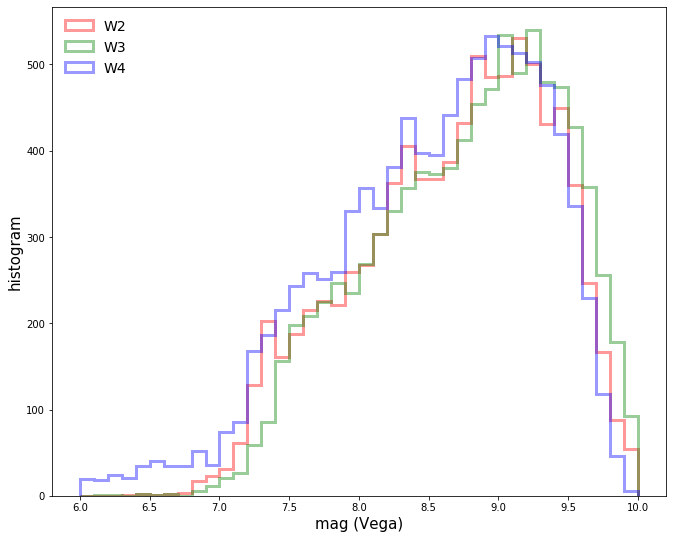

In [6]:
colors = list('rgb')
fig, ax = plt.subplots(1,1,figsize=(11,9))
for j in (1,2,3):
    ax.hist(df['w{:d}mpro'.format(j)],bins=40,range=(6,10),histtype='step',
            lw=3,color=colors[j-1],alpha=0.4,label='W{:d}'.format(j+1)) # lw=linewidth, alpha=transparency
ax.set_xlabel('mag (Vega)',fontsize=15)
ax.set_ylabel('histogram',fontsize=15)
ax.legend(loc='upper left',frameon=False,fontsize=14)

### A more complete example of photometry analysis using AllWISE can be found on our GitHub page [here](https://github.com/noaodatalab/notebooks-latest/tree/master/03_ScienceExamples/SpectralEnergyDistributions).


<a class="anchor" id="cmd"></a>
# Color-magnitude diagram of a dwarf galaxy
In this example we query for the photometry of stars around the known location of the Hydra II dwarf Galaxy, and generate a color-magnitude diagram (CDM) of them.

Let's define the query string. We ask for point-like objects `(abs(sharp<0.5))` in field number `169`, detected in long exposure images (`depthflag>1`), with `g` magnitudes between `9` and `25`, around a central position `ra0/dec0`, within `0.1` degrees radius. Where `ra0`,`dec0`, and `radius` are in decimal degrees.

In [7]:
field, ra0, dec0, radius = 169, 185.410559533, -31.9760034474, 0.1
query = """
SELECT ra,dec,gmag,rmag,imag FROM smash_dr1.object
  WHERE fieldid = {:d}
    AND depthflag > 1
    AND abs(sharp) < 0.5
    AND gmag BETWEEN 9 AND 25
    AND q3c_radial_query(ra,dec,{:f},{:f},{:f})
""".format(field,ra0,dec0,radius)

Submit the query, convert to Pandas dataframe, and display on-screen the first 5 rows:

In [8]:
response = qc.query(sql=query) # by default the result is a CSV formatted string
df = convert(response)
df.head()

,ra,dec,gmag,rmag,imag
0,185.347041,-31.900792,24.7889,24.5438,24.7477
1,185.322179,-31.916697,24.8761,23.9029,22.6424
2,185.325999,-31.906499,20.2757,20.2281,20.1026
3,185.327437,-31.912125,24.6747,23.8602,23.5007
4,185.328053,-31.918882,24.8699,24.7238,24.4339


Compute a color column (in the same dataframe) for g-r:

In [9]:
df['g_r'] = df['gmag'] - df['rmag']
df.head()

,ra,dec,gmag,rmag,imag,g_r
0,185.347041,-31.900792,24.7889,24.5438,24.7477,0.2451
1,185.322179,-31.916697,24.8761,23.9029,22.6424,0.9732
2,185.325999,-31.906499,20.2757,20.2281,20.1026,0.0476
3,185.327437,-31.912125,24.6747,23.8602,23.5007,0.8145
4,185.328053,-31.918882,24.8699,24.7238,24.4339,0.1461


Plot a color-magnitude diagram:

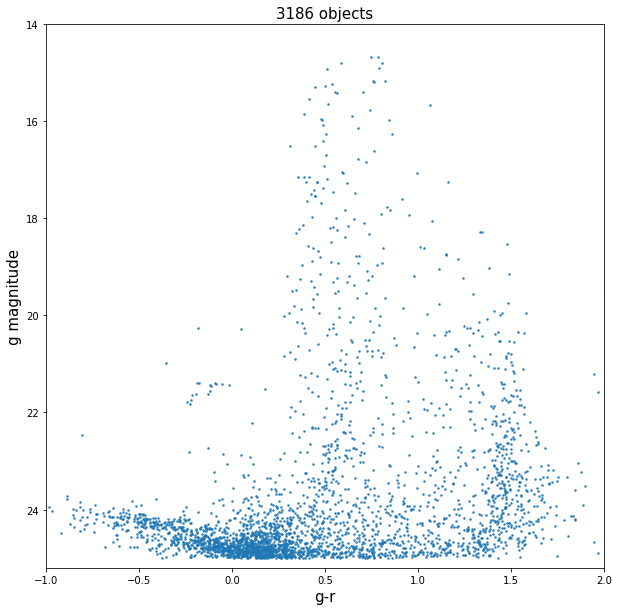

In [10]:
fig, ax = plt.subplots(figsize=(10,10))
x = df['g_r']
y = df['gmag']
ax.scatter(x,y,marker='.',s=10, alpha=0.8) # s = size, alpha = transparency of data points
ax.set_xlabel('g-r',fontsize=15)
ax.set_ylabel('g magnitude',fontsize=15)
ax.set_xlim((-1,2))
ax.set_ylim((25.2,14))
title = ax.set_title('{:d} objects'.format(len(df)),fontsize=15)

### A more complete example of the photometry of stars in dwarf galaxies can be found on our GitHub page [here](https://github.com/noaodatalab/notebooks-latest/tree/master/03_ScienceExamples/DwarfGalaxies).

<a class="anchor" id="lightcurve"></a>
# Light curve of RR Lyrae star
Some catalogs have multi-epoch data, such as the SMASH survey. We will query for the magnitudes and their errors of all measurements of a RR Lyrae star in Hydra II dwarf galaxy, whose unique ID we know.

We will ask the query to SELECT the following columns: RA, Dec, modified Julian date (mjd), calibrated mag (cmag), uncertainities (cerr), and filter band. Then order the returned rows by ascending mod. Julian date.

Note: this database table encodes 'no measurement' values as 99.99

In [11]:
objID = '169.429960'

query = """SELECT ra,dec,mjd,cmag,cerr,filter
        FROM smash_dr1.source
        WHERE id='{:s}' AND cmag<99
        ORDER BY mjd ASC""".format(objID)

Submit the query, convert to Pandas dataframe, and display on-screen the first 5 rows:

In [12]:
result = qc.query(sql=query) # by default the result is a CSV formatted string
df = convert(result)
df.head()

,ra,dec,mjd,cmag,cerr,filter
0,185.431155,-31.995327,56371.327538,21.4331,0.020651,g
1,185.431146,-31.995324,56371.328563,21.2316,0.022473,r
2,185.431139,-31.995320,56371.329582,21.1491,0.026192,i
3,185.431142,-31.995334,56371.330610,21.2379,0.045429,z
4,185.431145,-31.995325,56371.331633,21.3467,0.015112,g


Let's plot the lightcurve as function of date with error bars:

Text(0, 0.5, 'g magnitude')

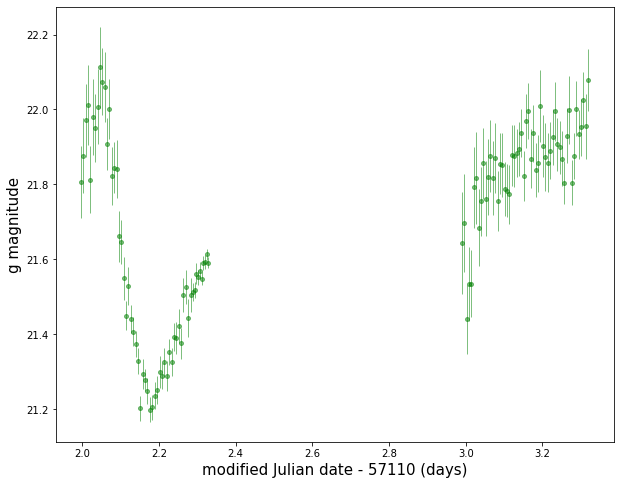

In [13]:
fig, ax = plt.subplots(figsize=(10,8))
co = (df['filter']=='g')
start = 16
jd0 = 57110
ax.errorbar(df['mjd'][co][start:]-jd0,df['cmag'][co][start:],
            yerr=df['cerr'][co][start:],marker='.',ms=8,ls='none',
            color='g',lw=1,alpha=0.5,label='') # ms=marker size, ls=linestyle, lw=linewidth, alpha=transparency
ax.set_xlabel('modified Julian date - {:d} (days)'.format(jd0),fontsize=15)
ax.set_ylabel('g magnitude',fontsize=15)

### A more complete example of time series analysis can be found on our GitHub page [here](https://github.com/noaodatalab/notebooks-latest/tree/master/03_ScienceExamples/TimeSeriesAnalysisRrLyraeStar). 